# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS - M7 Second Semester Project** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:
1. Feature selection.
2. Creating a Feature View.
3. Training datasets creation - splitting into train and test sets.
4. Training the model.
5. Register the model to Hopsworks Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages
We start with importing some of the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# Importing the packages and libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to Hopsworks Feature Store so we can retrieve the Feature Groups and select features for training data.

In [2]:
# Importing the hopsworks module for interacting with the Hopsworks platform
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/554133
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Retrieve the feature groups
electricity_fg = fs.get_feature_group(
    name='electricity_prices',
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather_measurements',
    version=1,
)

danish_calendar_fg = fs.get_feature_group(
    name='dk_calendar',
    version=1,
)

## <span style="color:#2656a3;"> 🖍 Feature View Creation and Retrieving </span>

We first select the features that we want to include for model training.

Since we specified `primary_key`as `date` and `timestamp` in `1_feature_backfill` we can now join them together for the `electricity_fg`, `weather_fg` and `danish_holiday_fg`.

`join_type` specifies the type of join to perform. An inner join refers to only retaining the rows based on the keys present in all joined DataFrames.

In [4]:
# Select features for training data and join them together and except duplicate columns
selected_features_training = electricity_fg.select_all()\
    .join(weather_fg.select_except(["timestamp", "datetime", "hour"]), join_type="inner")\
    .join(danish_calendar_fg.select_all(), join_type="inner")

In [5]:
# transformation_functions = {
#         "hour": fs.get_transformation_function(name="min_max_scaler"),
#         "dk1_spotpricedkk_kwh": fs.get_transformation_function(name="min_max_scaler"),
#         "temperature_2m": fs.get_transformation_function(name="min_max_scaler"),
#         "relative_humidity_2m": fs.get_transformation_function(name="min_max_scaler"),
#         "precipitation": fs.get_transformation_function(name="min_max_scaler"),
#         "rain": fs.get_transformation_function(name="min_max_scaler"),
#         "snowfall": fs.get_transformation_function(name="min_max_scaler"),
#         "weather_code": fs.get_transformation_function(name="min_max_scaler"),
#         "cloud_cover": fs.get_transformation_function(name="min_max_scaler"),
#         "wind_speed_10m": fs.get_transformation_function(name="min_max_scaler"),
#         "wind_gusts_10m": fs.get_transformation_function(name="min_max_scaler"),
#         "dayofweek": fs.get_transformation_function(name="min_max_scaler"),
#         "day": fs.get_transformation_function(name="min_max_scaler"),
#         "month": fs.get_transformation_function(name="min_max_scaler"),
#         "year": fs.get_transformation_function(name="min_max_scaler"),
#         "workday": fs.get_transformation_function(name="min_max_scaler"),
#     }


In [6]:
# Display the first 5 rows of the selected features
selected_features_training.show(5)

Finished: Reading data from Hopsworks, using ArrowFlight (3.63s) 


,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1688745600000,2023-07-07 16:00:00+00:00,2023-07-07 00:00:00+00:00,16,0.59802,20.3,57.0,0.0,0.0,0.0,0.0,17.0,17.4,35.3,4,7,7,2023,1
1,1660867200000,2022-08-19 00:00:00+00:00,2022-08-19 00:00:00+00:00,0,3.79462,12.8,95.0,0.0,0.0,0.0,1.0,26.0,4.2,13.3,4,19,8,2022,1
2,1673035200000,2023-01-06 20:00:00+00:00,2023-01-06 00:00:00+00:00,20,1.03449,6.0,90.0,0.4,0.4,0.0,51.0,74.0,17.9,34.2,4,6,1,2023,1
3,1681880400000,2023-04-19 05:00:00+00:00,2023-04-19 00:00:00+00:00,5,0.78883,5.3,77.0,0.0,0.0,0.0,0.0,0.0,12.7,22.3,2,19,4,2023,1
4,1714208400000,2024-04-27 09:00:00+00:00,2024-04-27 00:00:00+00:00,9,0.44051,7.4,74.0,0.1,0.1,0.0,51.0,90.0,5.4,16.6,5,27,4,2024,0


A `Feature View` stands between the **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create a **Feature View** which stores a metadata of our data. Having the **Feature View** we can create a **Training Dataset**.

In order to create Feature View we can use `fs.get_or_create_feature_view()` method.

We can specify parameters:

- `name` - Name of the feature view to create.
- `version` - Version of the feature view to create.
- `query` - Query object with the data.

In [7]:
# Getting or creating a feature view named 'dk1_electricity_training_feature_view'
version = 1
feature_view_training = fs.get_or_create_feature_view(
    name='dk1_electricity_training_feature_view',
    version=version,
    query=selected_features_training,
)

In [8]:
# # Getting or creating a feature view named 'dk1_electricity_training_feature_view'
# version = 1
# feature_view_training = fs.get_or_create_feature_view(
#     name='lstm_dk1_electricity_training_feature_view',
#     version=version,
#     transformation_functions=transformation_functions,
#     query=selected_features_training,
# )

## <span style="color:#2656a3;"> 🏋️ Training Dataset Creation</span>

In Hopsworks, a training dataset is generated from a query defined by the parent FeatureView, which determines the set of features.

**Training Dataset may contain splits such as:** 
* Training set: This subset of the training data is utilized for model training.
* Validation set: Used for evaluating hyperparameters during model training. *(We have not included a validation set for this project)*
* Test set: Reserved as a holdout subset of training data for evaluating a trained model's performance.

Training dataset is created using `fs.training_data()` method.

In [9]:
# Retrieve training data from the feature view 'feature_view_training', assigning the features to 'X'.
df, _ = feature_view_training.training_data(
    description = 'LSTM Electricity Prices Training Dataset',
)

Finished: Reading data from Hopsworks, using ArrowFlight (12.78s) 


In [10]:
# sort the data by timestamp and reset the index for time series data
df.sort_values(by='timestamp', ascending=True, inplace=True)
df = df.reset_index(drop=True)

df.head()

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1640995200000,2022-01-01 00:00:00+00:00,2022-01-01 00:00:00+00:00,0,0.37220,6.7,100.0,0.0,0.0,0.0,3.0,100.0,16.2,36.0,5,1,1,2022,0
1,1640998800000,2022-01-01 01:00:00+00:00,2022-01-01 00:00:00+00:00,1,0.30735,6.6,100.0,0.0,0.0,0.0,3.0,100.0,16.2,30.2,5,1,1,2022,0
2,1641002400000,2022-01-01 02:00:00+00:00,2022-01-01 00:00:00+00:00,2,0.32141,6.7,99.0,0.0,0.0,0.0,3.0,100.0,15.5,30.6,5,1,1,2022,0
3,1641006000000,2022-01-01 03:00:00+00:00,2022-01-01 00:00:00+00:00,3,0.33806,6.7,100.0,0.0,0.0,0.0,3.0,100.0,12.7,28.8,5,1,1,2022,0
4,1641009600000,2022-01-01 04:00:00+00:00,2022-01-01 00:00:00+00:00,4,0.28013,6.7,99.0,0.0,0.0,0.0,3.0,100.0,10.6,23.8,5,1,1,2022,0


## Train/Test Split LSTM Model

### Feature Selection

In [11]:
# Select features and target
features = df.drop(columns=['dk1_spotpricedkk_kwh','datetime','date','timestamp'])
target = df['dk1_spotpricedkk_kwh']

# Normalize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Normalize the target
target = target.values.reshape(-1, 1)
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target)

# Convert back to DataFrame for easier handling
features_scaled = pd.DataFrame(features_scaled, index=features.index, columns=features.columns)
target_scaled = pd.DataFrame(target_scaled, index=features.index, columns=['dk1_spotpricedkk_kwh'])

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


### Create Sequences for X and y

In [12]:
from sklearn.model_selection import train_test_split

def create_sequences(features, target, time_steps=24):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features.iloc[i:i+time_steps].values)
        y.append(target.iloc[i+time_steps].values)
    return np.array(X), np.array(y)

time_steps = 24  # Use the past 24 hours to predict the next hour
X, y = create_sequences(features_scaled, target_scaled, time_steps)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Build the LSTM Model

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])), # Set to True for multiple LSTM layers
    LSTM(50, return_sequences=False), # Set to False for the last LSTM layer
    Dense(1) # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_test, y_test)) # Increase epochs for better performance

Epoch 1/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0149 - val_loss: 0.0041
Epoch 2/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 3/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 4/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 5/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 6/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 9/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 11/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/ste

### Evaluate model

In [14]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 
Test Loss: 0.0011224778136238456


In [15]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and the true values to their original scale
y_pred_inverse = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

# Calculate performance metrics (e.g., RMSE)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Calculate performance metrics

rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

print(f'RMSE: {np.sqrt(rmse)}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 0.5717051638098122
MAE: 0.23600556535013037
MSE: 0.10682882696170819
R²: 0.8662605916490407


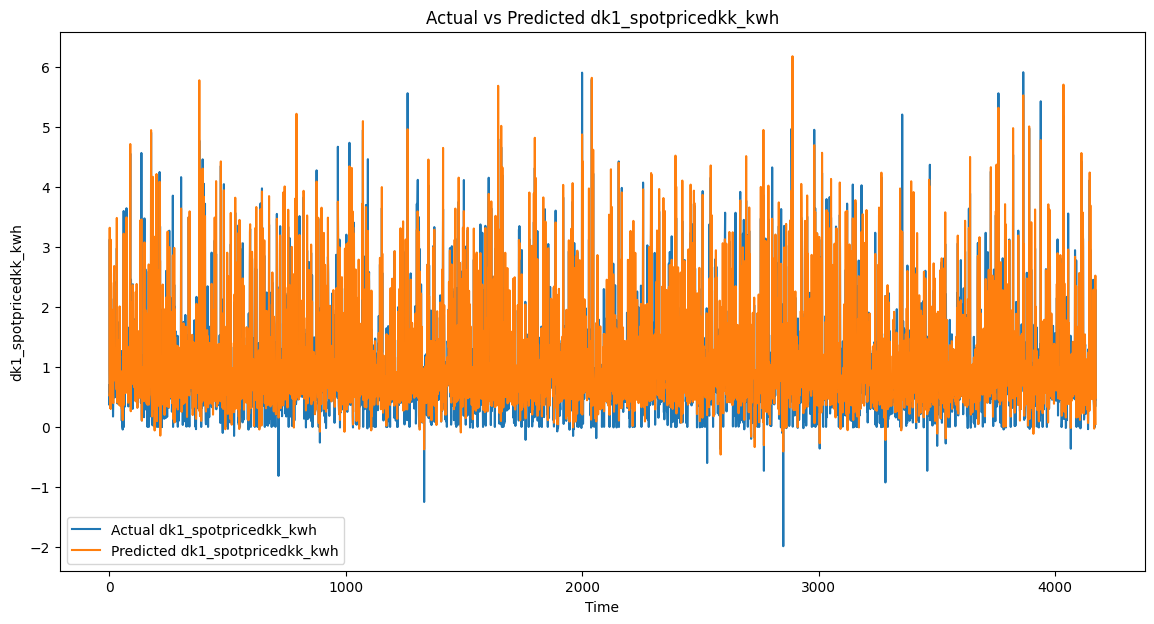

In [16]:
import matplotlib.pyplot as plt

# Plotting the true values and the predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual dk1_spotpricedkk_kwh')
plt.plot(y_pred_inverse, label='Predicted dk1_spotpricedkk_kwh')
plt.title('Actual vs Predicted dk1_spotpricedkk_kwh')
plt.xlabel('Time')
plt.ylabel('dk1_spotpricedkk_kwh')
plt.legend()
plt.show()

### Feature Importance

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


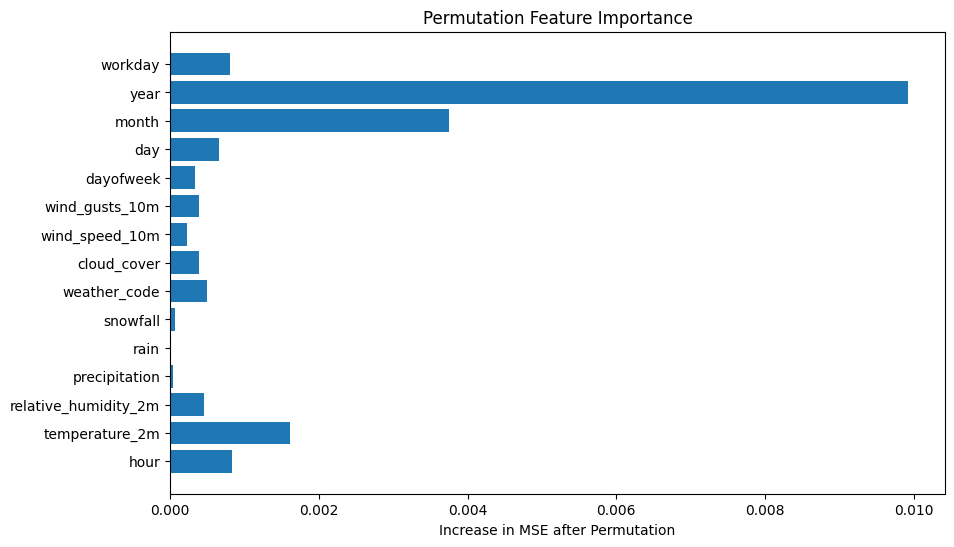

In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to calculate permutation feature importance
def permutation_feature_importance(model, X_val, y_val, feature_names):
    baseline_mse = mean_squared_error(y_val, model.predict(X_val))
    importances = []

    for col in range(X_val.shape[2]):
        X_val_permuted = np.copy(X_val)
        np.random.shuffle(X_val_permuted[:, :, col])
        permuted_mse = mean_squared_error(y_val, model.predict(X_val_permuted))
        importances.append(permuted_mse - baseline_mse)

    return np.array(importances), feature_names

# Calculate feature importance
importances, feature_names = permutation_feature_importance(model, X_test, y_test, features.columns)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel('Increase in MSE after Permutation')
plt.title('Permutation Feature Importance')
plt.show()

### Make Predictions

In [18]:
# Extract the last 5 predictions and their corresponding actual values
last_5_predictions = y_pred_inverse[-5:]
last_5_actuals = y_test_inverse[-5:]

# Print the last 5 predictions and their actual values
print("Last 5 Predictions vs Actual Values:")
for i in range(5):
    print(f"Prediction: {last_5_predictions[i][0]:.4f}, Actual: {last_5_actuals[i][0]:.4f}")

Last 5 Predictions vs Actual Values:
Prediction: 0.3745, Actual: 0.0000
Prediction: 1.5358, Actual: 1.4822
Prediction: 0.4703, Actual: 0.4397
Prediction: 2.5226, Actual: 2.2893
Prediction: 0.0504, Actual: 0.3542


## Temporal LSTM model

### Preprocess the Data

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming your DataFrame is named df


# Selecting the relevant features and target
features = df.drop(columns=['dk1_spotpricedkk_kwh','datetime','date','timestamp'])

target = df['dk1_spotpricedkk_kwh'].values.reshape(-1, 1)

# Scaling the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)


See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


### Create Sequences

In [20]:
def create_sequences(features, target, time_steps=24):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 24  # For hourly data, 24 time steps correspond to one day
X, y = create_sequences(features_scaled, target_scaled, time_steps)

### Split the Data

In [21]:
# Train-test split
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

### Build the LSTM Model

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

### Train the Model

In [23]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0095 - val_loss: 0.0039
Epoch 2/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 3/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 4/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0025 - val_loss: 9.6414e-04
Epoch 5/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 7/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 8/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 9/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 12/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms

### Evaluate the Model

In [24]:
loss = model.evaluate(X_test, y_test)
print(f'Val Loss: {loss}')

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012
Val Loss: 0.0008028277079574764


In [25]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and the true values to their original scale
y_pred_inverse = scaler_target.inverse_transform(y_pred)
y_test_inverse = scaler_target.inverse_transform(y_test)

# Calculate performance metrics (e.g., RMSE)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Calculate performance metrics

rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

print(f'RMSE: {np.sqrt(rmse)}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2: {r2}')

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 0.5257548276825873
MAE: 0.20049139906609906
MSE: 0.07640698747509643
R2: -0.08693404202592703


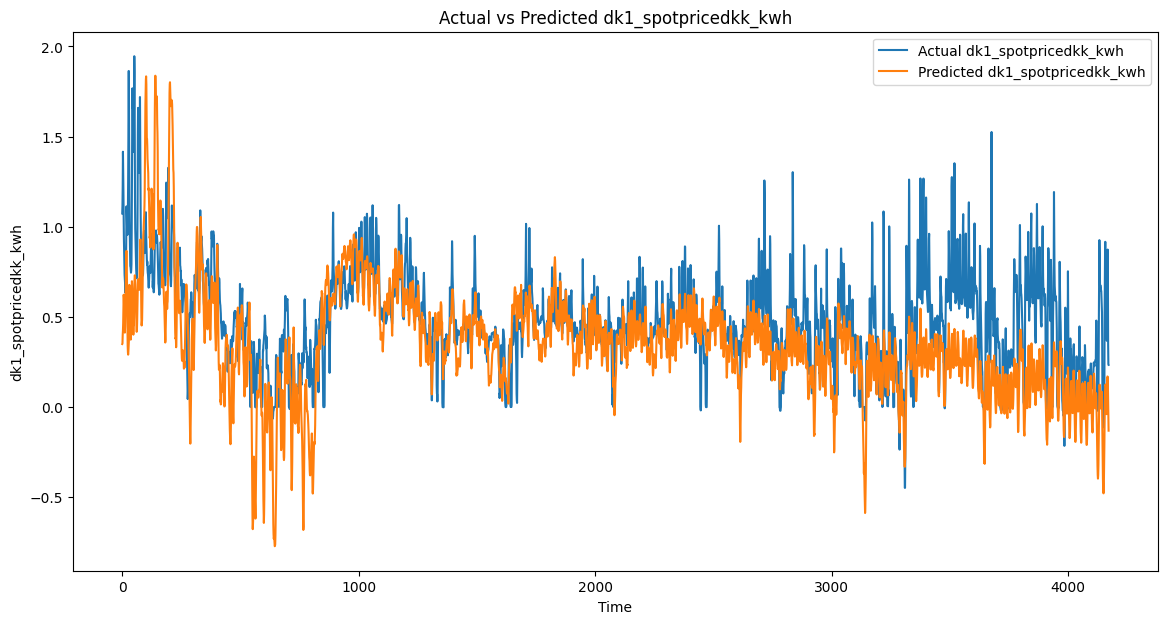

In [26]:
import matplotlib.pyplot as plt

# Plotting the true values and the predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual dk1_spotpricedkk_kwh')
plt.plot(y_pred_inverse, label='Predicted dk1_spotpricedkk_kwh')
plt.title('Actual vs Predicted dk1_spotpricedkk_kwh')
plt.xlabel('Time')
plt.ylabel('dk1_spotpricedkk_kwh')
plt.legend()
plt.show()

### Feature Importance

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


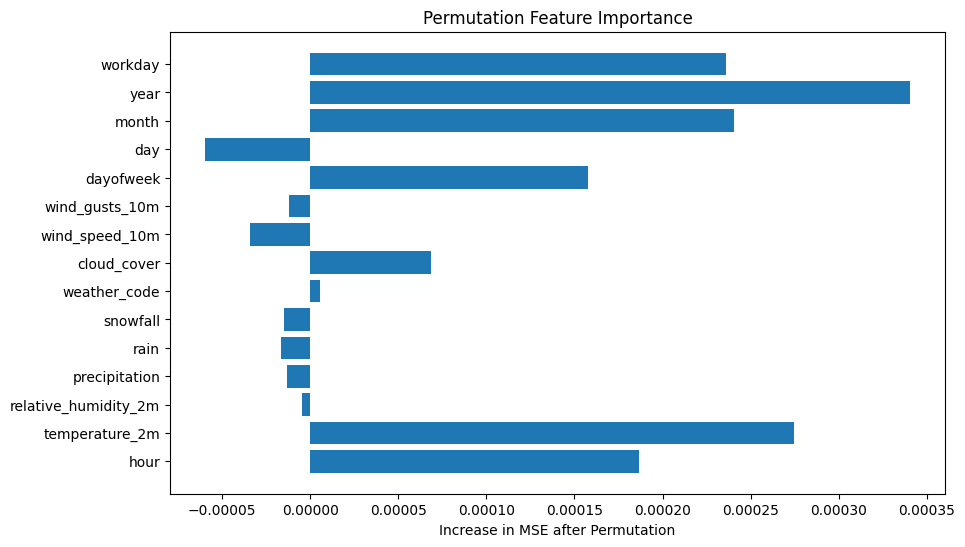

In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to calculate permutation feature importance
def permutation_feature_importance(model, X_val, y_val, feature_names):
    baseline_mse = mean_squared_error(y_val, model.predict(X_val))
    importances = []

    for col in range(X_val.shape[2]):
        X_val_permuted = np.copy(X_val)
        np.random.shuffle(X_val_permuted[:, :, col])
        permuted_mse = mean_squared_error(y_val, model.predict(X_val_permuted))
        importances.append(permuted_mse - baseline_mse)

    return np.array(importances), feature_names

# Calculate feature importance
importances, feature_names = permutation_feature_importance(model, X_test, y_test, features.columns)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel('Increase in MSE after Permutation')
plt.title('Permutation Feature Importance')
plt.show()

### Make predictions

In [28]:
# Extract the last 5 predictions and their corresponding actual values
last_5_predictions = y_pred_inverse[-5:]
last_5_actuals = y_test_inverse[-5:]

# Print the last 5 predictions and their actual values
print("Last 5 Predictions vs Actual Values:")
for i in range(5):
    print(f"Prediction: {last_5_predictions[i][0]:.4f}, Actual: {last_5_actuals[i][0]:.4f}")

Last 5 Predictions vs Actual Values:
Prediction: 0.1681, Actual: 0.8737
Prediction: 0.1192, Actual: 0.7192
Prediction: 0.0396, Actual: 0.3506
Prediction: -0.0479, Actual: 0.2378
Prediction: -0.1308, Actual: 0.2344


In [29]:
# Extract the last 5 predictions and their corresponding actual values
last_5_predictions = y_pred_inverse[-5:]
last_5_actuals = y_test_inverse[-5:]

# Print the last 5 predictions and their actual values
print("Last 5 Predictions vs Actual Values:")
for i in range(5):
    print(f"Prediction: {last_5_predictions[i][0]:.4f}, Actual: {last_5_actuals[i][0]:.4f}")

Last 5 Predictions vs Actual Values:
Prediction: 0.1681, Actual: 0.8737
Prediction: 0.1192, Actual: 0.7192
Prediction: 0.0396, Actual: 0.3506
Prediction: -0.0479, Actual: 0.2378
Prediction: -0.1308, Actual: 0.2344


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, BatchNormalization, LeakyReLU, MaxPooling1D, Bidirectional, Dropout

def build_model(input_dim):
    # Creating a Sequential model
    model = Sequential()

    # Adding a 1D convolutional layer
    model.add(Conv1D(filters=64, kernel_size=1, padding='same', kernel_initializer="uniform", input_shape=(input_dim[0], input_dim[1])))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Adding 1D convolutional layer
    model.add(Conv1D(filters=32, kernel_size=1, padding='same', kernel_initializer="uniform"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Adding 1D convolutional layer
    model.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer="uniform"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # Adding a 1D max pooling layer
    model.add(MaxPooling1D(pool_size=1, padding='same'))

    # Adding a Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
    model.add(Dropout(rate=0.1))

    # Adding a second LSTM layer
    model.add(LSTM(units=50, return_sequences=False))
    
    # Adding a Dense layer
    model.add(Dense(units=1))  # Output layer

    # Displaying the model summary
    model.summary()

    # Compiling the model with mean squared error loss and the Adam optimizer
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Example usage:
# Assuming X_train, y_train, X_test, y_test are already defined and preprocessed
# input_dim should be (sequence_length, num_features)
input_dim = (X_train.shape[1], X_train.shape[2])
model = build_model(input_dim)

# Train the model
history = model.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 24, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 24, 100)        │        26,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,131 (238.79 KB)

 Trainable params: 60,907 (237.92 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0144 - val_loss: 9.3202e-04
Epoch 2/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0033 - val_loss: 5.5548e-04
Epoch 3/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0025 - val_loss: 4.8971e-04
Epoch 4/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0024 - val_loss: 9.0353e-04
Epoch 5/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0020 - val_loss: 6.5377e-04
Epoch 6/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0019 - val_loss: 5.0302e-04
Epoch 7/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0017 - val_loss: 5.2569e-04
Epoch 8/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0016 - val_loss: 5.2884e-04
Epoch 9/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0016 - val_loss: 4.1552e-04
Epoch 10/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 11/12
522/522 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0013 - val_loss: 0.0015
Epo

In [31]:
# Extracting the training history dictionary from the model training
history_dict = history.history

# Displaying the keys in the history dictionary
print(history_dict.keys())

dict_keys(['loss', 'val_loss'])


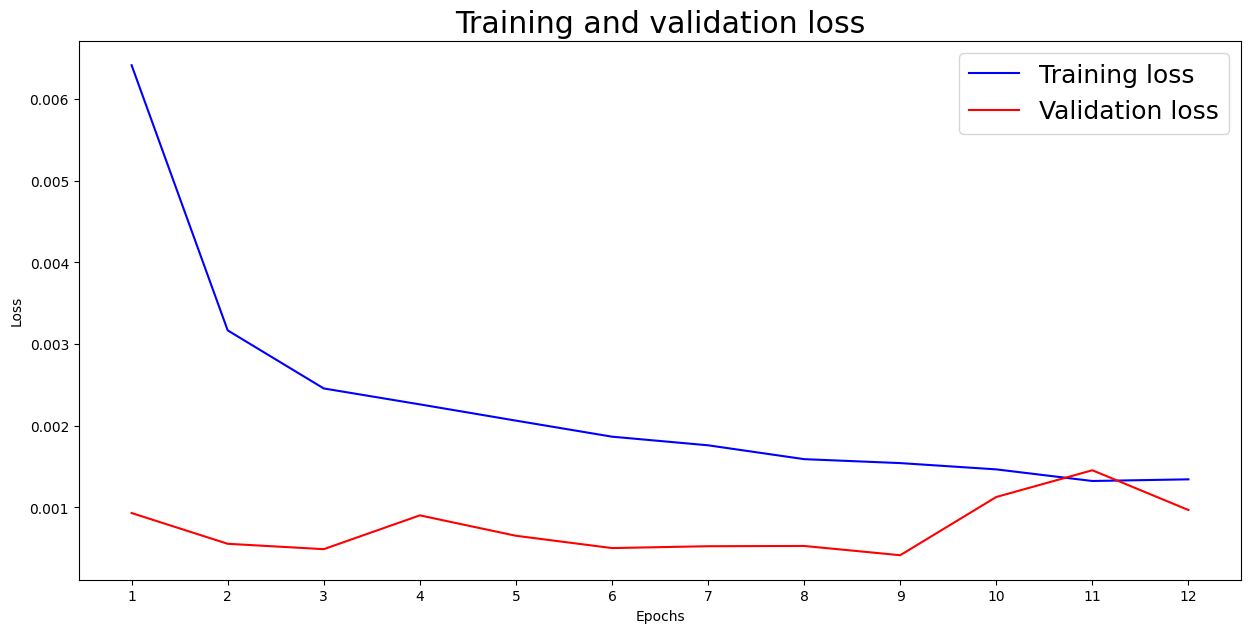

In [32]:
# Extracting training and validation loss values from the history dictionary
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Creating separate variables for loss values (50 epochs)
loss_values50 = loss_values
val_loss_values50 = val_loss_values

# Generating a plot for training and validation loss over epochs
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b', color='red', label='Validation loss')

# Setting plot details and labels
plt.rc('font', size=18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)

# Adjusting the size of the plot
fig = plt.gcf()
fig.set_size_inches(15, 7)

# Displaying the plot
plt.show()

In [33]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and the true values to their original scale
y_pred_inverse = scaler_target.inverse_transform(y_pred)
y_test_inverse = scaler_target.inverse_transform(y_test)

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


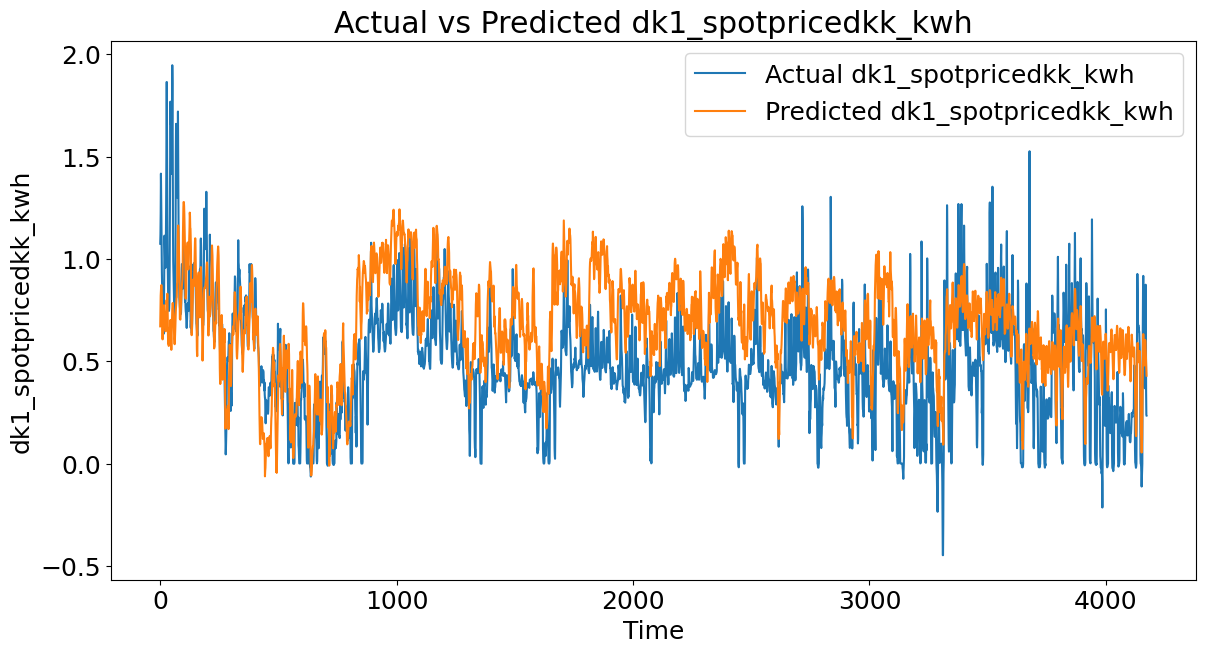

In [34]:
import matplotlib.pyplot as plt

# Plotting the true values and the predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual dk1_spotpricedkk_kwh')
plt.plot(y_pred_inverse, label='Predicted dk1_spotpricedkk_kwh')
plt.title('Actual vs Predicted dk1_spotpricedkk_kwh')
plt.xlabel('Time')
plt.ylabel('dk1_spotpricedkk_kwh')
plt.legend()
plt.show()

In [35]:
# Calculate performance metrics

rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

print(f'RMSE: {np.sqrt(rmse)}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2: {r2}')

RMSE: 0.5510557102753215
MAE: 0.2596163678929332
MSE: 0.09221085063941735
R2: -0.3117532298576524


In [36]:
# Extract the last 5 predictions and their corresponding actual values
last_5_predictions = y_pred_inverse[-5:]
last_5_actuals = y_test_inverse[-5:]

# Print the last 5 predictions and their actual values
print("Last 5 Predictions vs Actual Values:")
for i in range(5):
    print(f"Prediction: {last_5_predictions[i][0]:.4f}, Actual: {last_5_actuals[i][0]:.4f}")

Last 5 Predictions vs Actual Values:
Prediction: 0.5591, Actual: 0.8737
Prediction: 0.5284, Actual: 0.7192
Prediction: 0.4841, Actual: 0.3506
Prediction: 0.4529, Actual: 0.2378
Prediction: 0.4291, Actual: 0.2344


### <span style="color:#2656a3;"> ⛳️ Dataset with train and test splits</span>

Here we define our train and test splits for traning the model.

## <span style="color:#2656a3;">🗃 Window timeseries</span>

For this case, let’s assume that given the past 10 days observation, we need to forecast the next 5 days observations.

## <span style="color:#2656a3;">🧬 Modeling</span>

For Modeling we initialize the `XGBoost Regressor`.

The XGBoost Regressor is a powerful and versatile algorithm known for its effectiveness in a wide range of regression tasks, including predictive modeling and time series forecasting. Specifically tailored for regression tasks, it aims to predict continuous numerical values. The algorithm constructs an ensemble of regression trees, optimizing them to minimize a specified loss function, commonly the mean squared error for regression tasks. Ultimately, the final prediction is derived by aggregating the predictions of individual trees.

As shown in the above feature importance plot features like `temperature`, `day`, `hour` and `month` are most important for predicting the dependent variable. 

## <span style='color:#2656a3'>🗄 Model Registry</span>

The Model Registry in Hopsworks enable us to store the trained model. The model registry centralizes model management, enabling models to be securely accessed and governed. We can also save model metrics with the model, enabling the user to understand performance of the model on test (or unseen) data.

In [37]:
# Exporting the trained model to a directory
model_dir = "lstm_electricity_price_model"
print('Exporting trained model to: {}'.format(model_dir))

# Saving the model using TensorFlow's saved_model.save function
tf.saved_model.save(model, model_dir)

Exporting trained model to: lstm_electricity_price_model
INFO:tensorflow:Assets written to: lstm_electricity_price_model/assets
INFO:tensorflow:Assets written to: lstm_electricity_price_model/assets


### <span style="color:#ff5f27;">⚙️ Model Schema</span>
A model schema defines the structure and format of the input and output data that a machine learning model expects and produces, respectively. It serves as a **blueprint** for understanding how to interact with the model in terms of input features and output predictions. In the context of the Hopsworks platform, a model schema is typically defined using the Schema class, which specifies the features expected in the input data and the target variable in the output data. This schema helps ensure consistency and compatibility between the model and the data it operates on.

In [38]:
# Importing the libraries for saving the model
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

In [39]:
# # Specify the schema of the model's input and output using the features (X_train) and dependent variable (y_train)
# input_schema = Schema(X_train)
# output_schema = Schema(y_train)

# # Create a model schema using the input and output schemas
# model_schema = ModelSchema(input_schema, output_schema)

In [40]:
# Retrieving the Model Registry
mr = project.get_model_registry()

# Extracting loss value from the training history
metrics = {'loss': history_dict['val_loss'][0]} 

# Creating a TensorFlow model in the Model Registry
tf_model = mr.tensorflow.create_model(
    name="lstm_electricity_price_model",
    metrics=metrics,
    #model_schema=model_schema,
    description="LSTM Daily electricity price prediction model.",
    #input_example=X_train[:1]
)

# Saving the model to the specified directory
tf_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/56 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/483452 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/747349 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/4461 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/554133/models/lstm_electricity_price_model/1


Model(name: 'lstm_electricity_price_model', version: 1)

## <span style="color:#2656a3;">⏭️ **Next:** Part 04: Batch Inference </span>

Next notebook we will use the registered model to make predictions based on the batch data.